<a href="https://colab.research.google.com/github/Sameer0Rai/Text-Sentence-Similarity-TOPSIS/blob/main/TopsisOnPretrainedModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import requests
from bs4 import BeautifulSoup
import re
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer, util
from IPython.display import display

In [29]:
def get_real_sentences():
    sentences = []

    try:
        url = "https://en.wikipedia.org/wiki/Natural_language_processing"
        r = requests.get(url, timeout=10)
        soup = BeautifulSoup(r.text, "html.parser")

        paragraphs = soup.find_all("p")
        text = " ".join(p.get_text() for p in paragraphs)
        text = re.sub(r"\[\d+\]", "", text)

        sentences = [
            s.strip() for s in text.split(".")
            if len(s.strip()) > 25
        ]
    except:
        pass


    if len(sentences) < 5:
        sentences = [
            "Natural language processing enables machines to understand human language.",
            "Sentence similarity measures how close two pieces of text are in meaning.",
            "Transformer based models improve contextual understanding.",
            "Pre trained models reduce the requirement for large labeled datasets.",
            "Cosine similarity is widely used to compare sentence embeddings.",
            "Efficient models are preferred for real time applications.",
            "Text similarity is crucial for search engines and chatbots."
        ]

    return sentences


sentences = get_real_sentences()
sentence_pairs = list(zip(sentences[:-1], sentences[1:]))

print(f"Total sentence pairs: {len(sentence_pairs)}")
print("Sample pair:\n", sentence_pairs[0])


Total sentence pairs: 6
Sample pair:
 ('Natural language processing enables machines to understand human language.', 'Sentence similarity measures how close two pieces of text are in meaning.')


In [30]:
models = {
    "MiniLM": "all-MiniLM-L6-v2",
    "MPNet": "all-MPNet-base-v2",
    "Paraphrase-MiniLM": "paraphrase-MiniLM-L6-v2",
    "DistilBERT-NLI": "distilbert-base-nli-stsb-mean-tokens",
    "BERT-NLI": "bert-base-nli-mean-tokens"
}

In [31]:
results = []

for name, model_name in models.items():
    print(f"Evaluating {name}...")
    model = SentenceTransformer(model_name)

    start = time.time()
    similarities = []

    for s1, s2 in sentence_pairs:
        emb1 = model.encode(s1, convert_to_tensor=True)
        emb2 = model.encode(s2, convert_to_tensor=True)
        sim = util.cos_sim(emb1, emb2).item()
        similarities.append(sim)

    end = time.time()

    results.append({
        "Model": name,
        "Accuracy": round(np.mean(similarities), 4),
        "Inference Time (ms)": round((end - start) * 1000, 2),
        "Embedding Dimension": model.get_sentence_embedding_dimension(),
        "Model Size (proxy)": len(model.state_dict())
    })

evaluation_df = pd.DataFrame(results)
display(evaluation_df)

Evaluating MiniLM...


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Evaluating MPNet...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

MPNetModel LOAD REPORT from: sentence-transformers/all-MPNet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Evaluating Paraphrase-MiniLM...


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/paraphrase-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Evaluating DistilBERT-NLI...


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating BERT-NLI...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/bert-base-nli-mean-tokens
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


,Model,Accuracy,Inference Time (ms),Embedding Dimension,Model Size (proxy)
0,MiniLM,0.2190,286.57,384,103
1,MPNet,0.2486,1484.73,768,199
2,Paraphrase-MiniLM,0.1760,292.63,384,103
3,DistilBERT-NLI,0.3032,1087.16,768,100
4,BERT-NLI,0.4903,1793.42,768,199


In [32]:
decision_matrix = evaluation_df[
    ["Accuracy", "Inference Time (ms)", "Embedding Dimension", "Model Size (proxy)"]
].values

weights = np.array([0.4, 0.2, 0.2, 0.2])     # Sum = 1
criteria = np.array([1, -1, -1, -1])        # 1 = benefit, -1 = cost


In [33]:
def topsis(matrix, weights, criteria):
    norm_matrix = matrix / np.sqrt((matrix ** 2).sum(axis=0))
    weighted_matrix = norm_matrix * weights

    ideal_best = np.where(criteria == 1,
                          weighted_matrix.max(axis=0),
                          weighted_matrix.min(axis=0))

    ideal_worst = np.where(criteria == 1,
                           weighted_matrix.min(axis=0),
                           weighted_matrix.max(axis=0))

    dist_best = np.sqrt(((weighted_matrix - ideal_best) ** 2).sum(axis=1))
    dist_worst = np.sqrt(((weighted_matrix - ideal_worst) ** 2).sum(axis=1))

    score = dist_worst / (dist_best + dist_worst)
    return score

In [34]:
evaluation_df["TOPSIS Score"] = topsis(decision_matrix, weights, criteria)
evaluation_df["Rank"] = evaluation_df["TOPSIS Score"].rank(ascending=False)

final_df = evaluation_df.sort_values("Rank")
display(final_df)

,Model,Accuracy,Inference Time (ms),Embedding Dimension,Model Size (proxy),TOPSIS Score,Rank
4,BERT-NLI,0.4903,1793.42,768,199,0.564891,1.0
0,MiniLM,0.2190,286.57,384,103,0.474108,2.0
3,DistilBERT-NLI,0.3032,1087.16,768,100,0.445899,3.0
2,Paraphrase-MiniLM,0.1760,292.63,384,103,0.433099,4.0
1,MPNet,0.2486,1484.73,768,199,0.206471,5.0


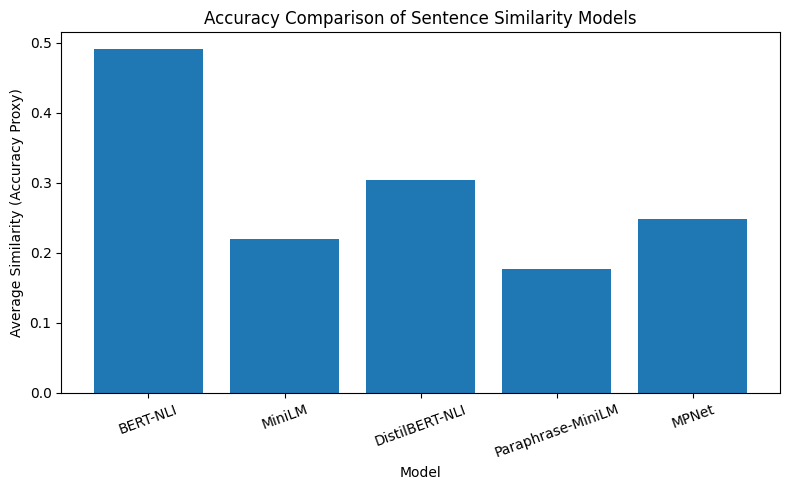

In [35]:
plt.figure(figsize=(8,5))
plt.bar(final_df["Model"], final_df["Accuracy"])
plt.xlabel("Model")
plt.ylabel("Average Similarity (Accuracy Proxy)")
plt.title("Accuracy Comparison of Sentence Similarity Models")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

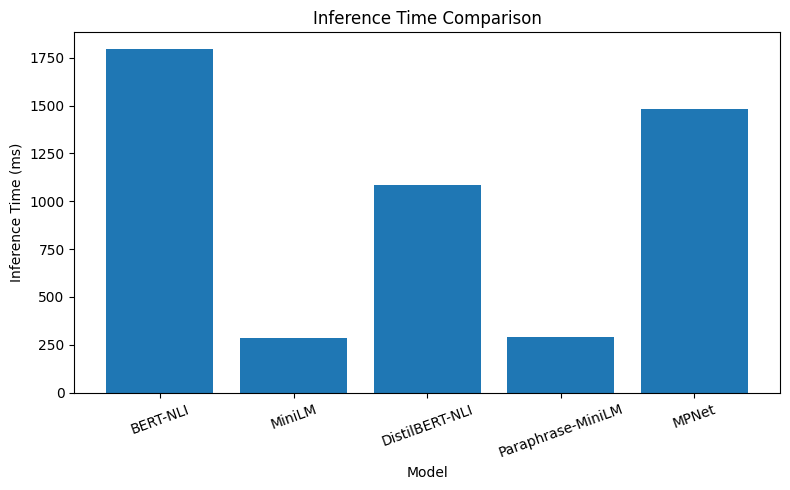

In [36]:
plt.figure(figsize=(8,5))
plt.bar(final_df["Model"], final_df["Inference Time (ms)"])
plt.xlabel("Model")
plt.ylabel("Inference Time (ms)")
plt.title("Inference Time Comparison")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

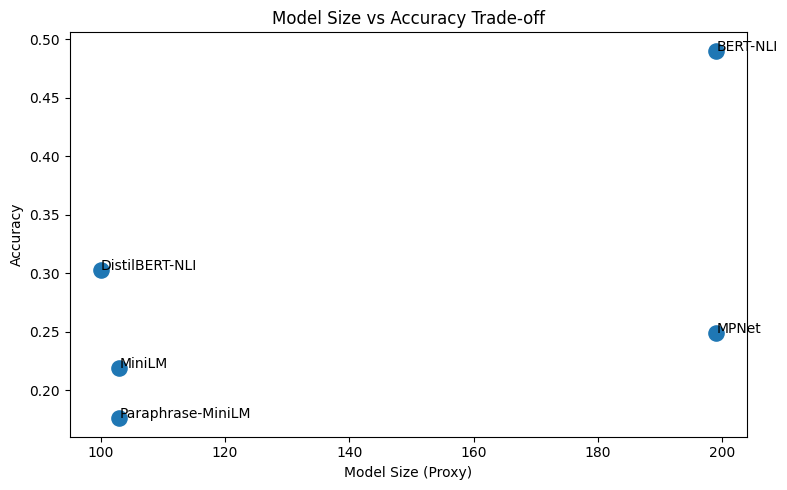

In [37]:
plt.figure(figsize=(8,5))
plt.scatter(
    final_df["Model Size (proxy)"],
    final_df["Accuracy"],
    s=120
)

for i, model in enumerate(final_df["Model"]):
    plt.text(
        final_df["Model Size (proxy)"].iloc[i],
        final_df["Accuracy"].iloc[i],
        model
    )

plt.xlabel("Model Size (Proxy)")
plt.ylabel("Accuracy")
plt.title("Model Size vs Accuracy Trade-off")
plt.tight_layout()
plt.show()

In [38]:
normalized = decision_matrix / np.sqrt((decision_matrix ** 2).sum(axis=0))
normalized_df = pd.DataFrame(
    normalized,
    columns=["Accuracy", "Time", "Embedding Dim", "Model Size"],
    index=evaluation_df["Model"]
)

display(normalized_df.round(4))

,Accuracy,Time,Embedding Dim,Model Size
Model,,,,
MiniLM,0.3184,0.1101,0.2673,0.3100
MPNet,0.3614,0.5706,0.5345,0.5989
Paraphrase-MiniLM,0.2559,0.1125,0.2673,0.3100
DistilBERT-NLI,0.4408,0.4178,0.5345,0.3009
BERT-NLI,0.7129,0.6892,0.5345,0.5989


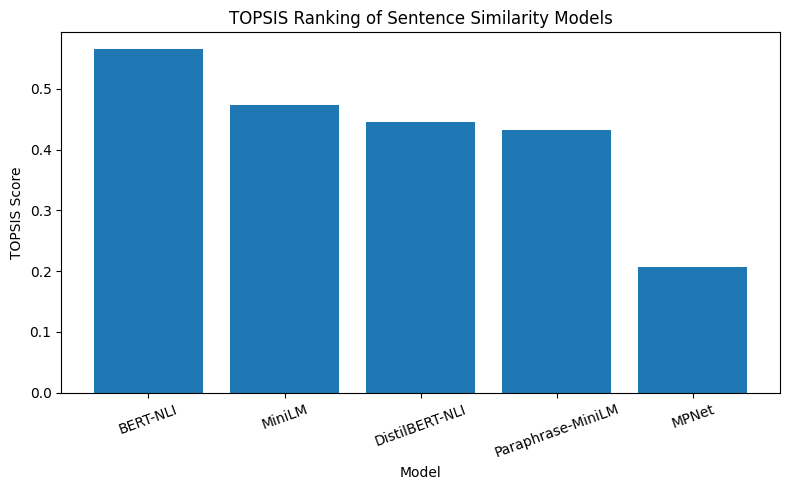

In [39]:
plt.figure(figsize=(8,5))
plt.bar(final_df["Model"], final_df["TOPSIS Score"])
plt.xlabel("Model")
plt.ylabel("TOPSIS Score")
plt.title("TOPSIS Ranking of Sentence Similarity Models")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

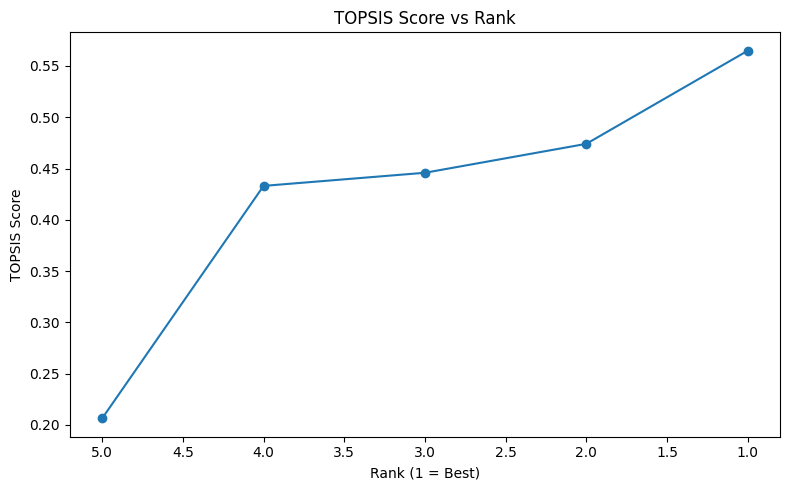

In [40]:
plt.figure(figsize=(8,5))
plt.plot(
    final_df["Rank"],
    final_df["TOPSIS Score"],
    marker="o"
)
plt.gca().invert_xaxis()

plt.xlabel("Rank (1 = Best)")
plt.ylabel("TOPSIS Score")
plt.title("TOPSIS Score vs Rank")
plt.tight_layout()
plt.show()

In [41]:
evaluation_df.to_csv("model_evaluation_metrics.csv", index=False)
final_df.to_csv("topsis_final_ranking.csv", index=False)

In [42]:
plt.figure(figsize=(8,5))
plt.bar(final_df["Model"], final_df["TOPSIS Score"])
plt.title("TOPSIS Scores")
plt.tight_layout()
plt.savefig("topsis_scores.png")
plt.close()

plt.figure(figsize=(8,5))
plt.bar(final_df["Model"], final_df["Accuracy"])
plt.title("Accuracy Comparison")
plt.tight_layout()
plt.savefig("accuracy_comparison.png")
plt.close()

plt.figure(figsize=(8,5))
plt.bar(final_df["Model"], final_df["Inference Time (ms)"])
plt.title("Inference Time Comparison")
plt.tight_layout()
plt.savefig("inference_time.png")
plt.close()

In [43]:
plt.figure(figsize=(8,5))
plt.scatter(
    final_df["Model Size (proxy)"],
    final_df["Accuracy"],
    s=120
)

for i, model in enumerate(final_df["Model"]):
    plt.text(
        final_df["Model Size (proxy)"].iloc[i],
        final_df["Accuracy"].iloc[i],
        model
    )

plt.xlabel("Model Size (Proxy)")
plt.ylabel("Accuracy")
plt.title("Model Size vs Accuracy Trade-off")
plt.tight_layout()
plt.savefig("model_size_vs_accuracy.png")
plt.close()

In [44]:
plt.figure(figsize=(8,5))
plt.plot(
    final_df["Rank"],
    final_df["TOPSIS Score"],
    marker="o"
)
plt.gca().invert_xaxis()

plt.xlabel("Rank (1 = Best)")
plt.ylabel("TOPSIS Score")
plt.title("Rank vs TOPSIS Score")
plt.tight_layout()
plt.savefig("rank_vs_topsis_score.png")
plt.close()

In [45]:
fig, ax = plt.subplots(figsize=(10,4))
ax.axis('off')

normalized = decision_matrix / np.sqrt((decision_matrix ** 2).sum(axis=0))
table_df = pd.DataFrame(
    normalized.round(4),
    columns=["Accuracy", "Time", "Embedding Dim", "Model Size"],
    index=final_df["Model"]
)

table = ax.table(
    cellText=table_df.values,
    colLabels=table_df.columns,
    rowLabels=table_df.index,
    loc='center'
)

table.scale(1, 1.5)
plt.title("Normalized Decision Matrix (TOPSIS)")
plt.savefig("normalized_decision_matrix.png")
plt.close()